### Make initial conditions for present day experiment

Based on observations from B-SOSE (http://sose.ucsd.edu/)

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import cartopy.crs as ccrs
import cmocean
import gsw
import tqdm
import sys
sys.path.append('/home/users/birgal/')
from nemo_python.interpolation import interp_latlon_cf, neighbours, neighbours_z, extend_into_mask
from nemo_python.ics_obcs import interp_depth, fill_mask, fill_near_bottom, vertical_edges, vertical_interp, ics_obcs_horizontal_interp, create_ics
from nemo_python.utils import fix_lon_range, convert_to_teos10

## Main

In [ ]:
THETA_file_SOSE = '/gws/nopw/j04/terrafirma/birgal/NEMO_AIS/B-SOSE/climatology/THETA_climatology_m01.nc';
output_file     = '/gws/nopw/j04/terrafirma/birgal/NEMO_AIS/THETA-SOSE-initial-conditions.nc'

create_ics('THETA', THETA_file_SOSE, output_file, 
           source       = 'SOSE',
           source_coord = '/gws/nopw/j04/terrafirma/birgal/NEMO_AIS/B-SOSE/THETA_climatology_m01.nc',
           nemo_coord   = '/gws/nopw/j04/terrafirma/birgal/NEMO_AIS/bathymetry/coordinates_AIS.nc',
           nemo_mask    = '/gws/nopw/j04/terrafirma/birgal/NEMO_AIS/bathymetry/mesh_mask-20231025.nc',
           salt_file    = '/gws/nopw/j04/terrafirma/birgal/NEMO_AIS/B-SOSE/climatology/SALT_climatology_m01.nc')

In [6]:
filled     = xr.open_dataset(f'/gws/nopw/j04/terrafirma/birgal/NEMO_AIS/initial-conditions/SOSE-SeaIceHeff-initial-conditions.nc')
not_filled = xr.open_dataset(f'/gws/nopw/j04/terrafirma/birgal/NEMO_AIS/initial-conditions/SOSE-SIheff-horizontal-interp.nc')

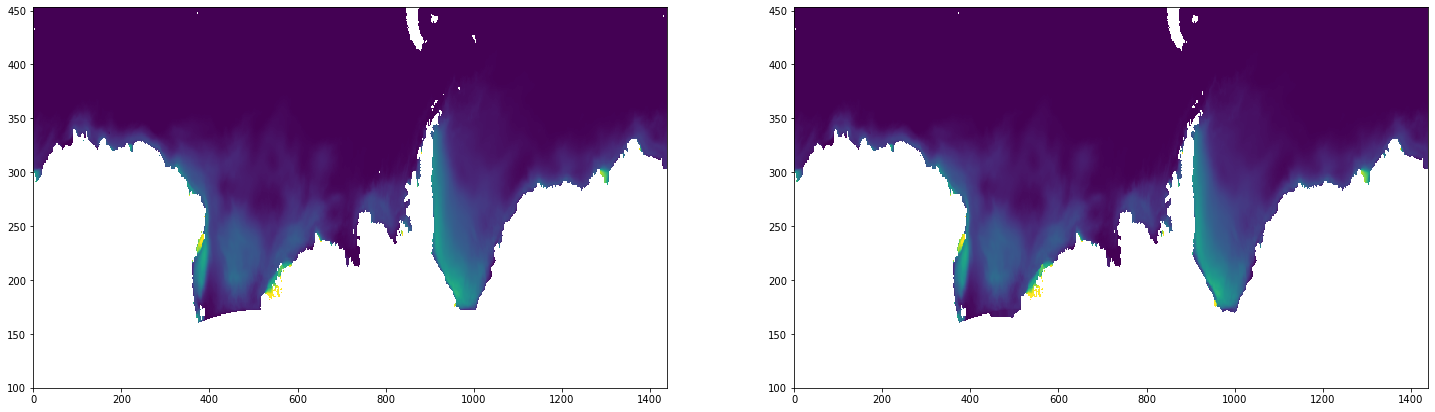

In [ ]:
vminm=0
vmaxm=3
fig, ax = plt.subplots(1,2, figsize=(25,7))
ax[0].pcolormesh(not_filled.SIheff, vmin=vminm, vmax=vmaxm)
ax[1].pcolormesh(filled.SIheff, vmin=vminm, vmax=vmaxm)

for axis in ax.ravel():
    axis.set_ylim(100,453)

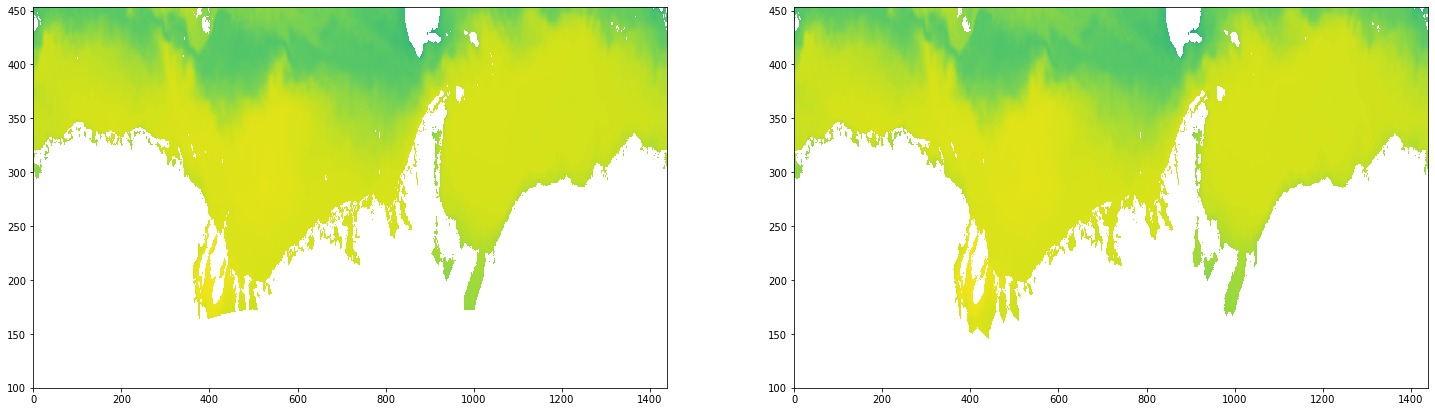

In [20]:
int=50
vminm=33
vmaxm=35
fig, ax = plt.subplots(1,2, figsize=(25,7))
ax[0].pcolormesh(vert_interp.SALT.isel(z=int), vmin=vminm, vmax=vmaxm)
ax[1].pcolormesh(SOSE_extended.SALT.isel(z=int), vmin=vminm, vmax=vmaxm)

for axis in ax.ravel():
    axis.set_ylim(100,453)